In [1]:
all.start.time = Sys.time()
options(warn=-1)

# import used package 
packages = c('plyr', 'ggplot2', 'recommenderlab', 'reshape2')
# install packages: if package already installed, then skip. 
# Otherwise, install it.
for (pkg in packages){
    if (!require(pkg, character.only = TRUE)){
        install.packages(pkg)
    } 
}

library(plyr)
library(ggplot2)
library(recommenderlab)
library(reshape2)

Loading required package: plyr
Loading required package: ggplot2
Loading required package: recommenderlab
Loading required package: Matrix
Loading required package: arules

Attaching package: ‘arules’

The following objects are masked from ‘package:base’:

    abbreviate, write

Loading required package: proxy

Attaching package: ‘proxy’

The following object is masked from ‘package:Matrix’:

    as.matrix

The following objects are masked from ‘package:stats’:

    as.dist, dist

The following object is masked from ‘package:base’:

    as.matrix

Loading required package: registry
Loading required package: reshape2


# Exlporatory Data Analysis

In [2]:
# read ratings.data
ratings = read.table('./data/ratings.dat', sep=':', header=FALSE, 
                     colClasses=c('integer', 'NULL'))
colnames(ratings) = c('user', 'movie', 'rating', 'timestamp')

# read movies.data
movies = readLines('./data/movies.dat')
movies = strsplit(movies, split='::', fixed=TRUE)
movies = matrix(unlist(movies), ncol=3, byrow=TRUE)
movies = data.frame(movies, stringsAsFactors=FALSE)
colnames(movies) = c('movie', 'title', 'genres')
movies$movie = as.integer(movies$movie)

In [3]:
head(ratings)

user,movie,rating,timestamp
1,1193,5,978300760
1,661,3,978302109
1,914,3,978301968
1,3408,4,978300275
1,2355,5,978824291
1,1197,3,978302268


In [4]:
head(movies)

movie,title,genres
1,Toy Story (1995),Animation|Children's|Comedy
2,Jumanji (1995),Adventure|Children's|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama
5,Father of the Bride Part II (1995),Comedy
6,Heat (1995),Action|Crime|Thriller


In [5]:
# change the value of Genres
movies$genres = ifelse(grepl('\\|', movies$genres), "Multiple", movies$genres)

# merge ratings and moview datasets
rating_merged = merge(x=ratings, y=movies, by.x="movie")

In [6]:
head(rating_merged)

movie,user,rating,timestamp,title,genres
1,3177,5,968786114,Toy Story (1995),Multiple
1,1142,4,974877362,Toy Story (1995),Multiple
1,1279,2,974856657,Toy Story (1995),Multiple
1,3219,4,968474051,Toy Story (1995),Multiple
1,1242,3,976308358,Toy Story (1995),Multiple
1,4535,4,964719374,Toy Story (1995),Multiple


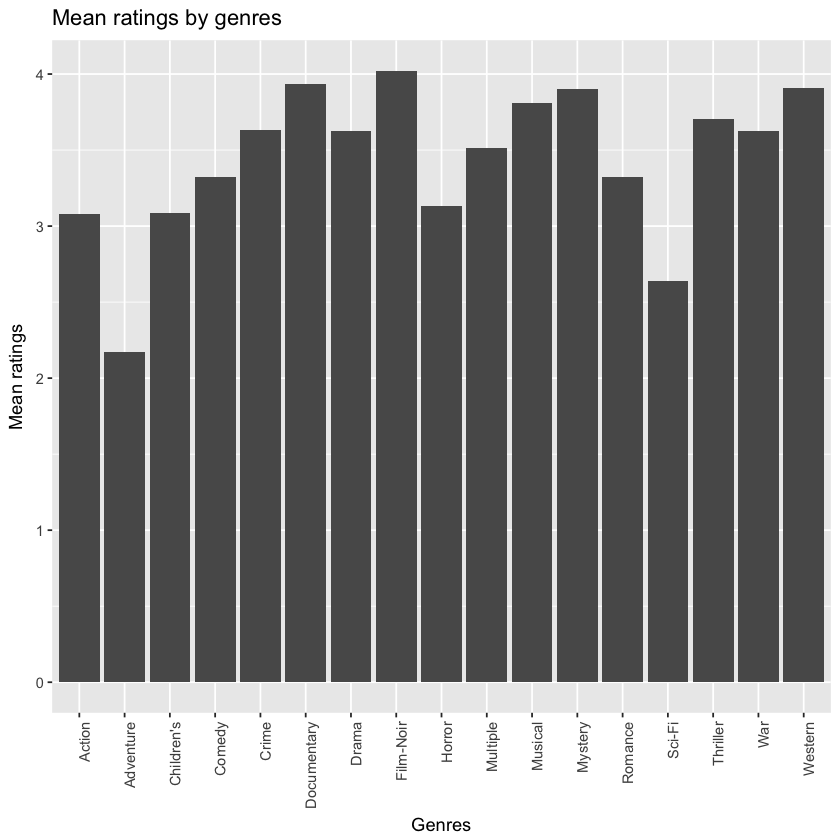

In [7]:
# plot of a bar graph
ggplot(rating_merged, aes(x=factor(genres), y=rating), color = factor(vs)) +
       stat_summary(fun.y=mean, position=position_dodge(), geom="bar") + 
       labs(x="Genres", y="Mean ratings", title="Mean ratings by genres") + 
       theme(axis.text.x=element_text(angle=90, hjust=1))

# Prepare training and test data

In [8]:
set.seed(100)
train.id = sample(nrow(ratings), floor(nrow(ratings)) * 0.6)
train = ratings[train.id, ]
write.table(train, file='train.dat', sep='::', row.names=FALSE, col.names=FALSE)

test = ratings[-train.id, ]
test.id = sample(nrow(test), floor(nrow(test)) * 0.5)
test = test[test.id, ]
test$Timestamp = NULL
test$ID = 1:nrow(test)
label = test[c('ID', 'rating')]
test$Rating = NULL
test = test[c('ID', 'user', 'movie')]
colnames(test) = c('ID', 'user', 'movie')

write.table(test, file='test.csv', sep=',', row.names=FALSE)
write.table(label, file='label.csv', sep=',', row.names=FALSE)

In [9]:
head(train)

,user,movie,rating,timestamp
307831,1835,2971,5,974882434
257727,1579,1381,3,989258329
552437,3401,2352,4,967433108
56395,376,1230,5,982551584
468646,2887,356,5,972270732
483870,2975,2020,4,971021844


In [10]:
head(test)

,ID,user,movie
432361,1,2636,2671
704220,2,4223,788
610490,3,3703,3873
328756,4,1941,1046
978872,5,5903,1617
549120,6,3389,880


# Recommerder System

In [11]:
# remove timestamp column
train$timestamp = NULL
head(train)

,user,movie,rating
307831,1835,2971,5
257727,1579,1381,3
552437,3401,2352,4
56395,376,1230,5
468646,2887,356,5
483870,2975,2020,4


In [12]:
# create a utility matrix
R = acast(train, user ~ movie)
R = as(R, 'realRatingMatrix')
R

Using rating as value column: use value.var to override.


6040 x 3649 rating matrix of class ‘realRatingMatrix’ with 600125 ratings.

   [[ suppressing 3649 column names ‘1’, ‘2’, ‘3’ ... ]]


6 x 3649 sparse Matrix of class "dgCMatrix"
                                                                               
1 . . . . .  .        . . . . . . . . .  .         .          . . . . . . . . .
2 . . . . .  .        . . . . . . . . .  .         .          . . . . . . . . .
3 . . . . .  .        . . . . . . . . .  .         .          . . . . . . . . .
4 . . . . .  .        . . . . . . . . .  .         .          . . . . . . . . .
5 . . . . . -1.183333 . . . . . . . . . -0.1833333 .          . . . . . . . . .
6 . . . . .  .        . . . . . . . . .  .         0.02380952 . . . . . . . . .
                                                                               
1 . . .        . . .         . .          . . . . . . . . . . . . . 0.81250 . .
2 . . .        . . .         . .          . . . . . . . . . . . . . .       . .
3 . . .        . . .         . .          . . . . . . . . . . . . . .       . .
4 . . .        . . .         . .          . . . . . . . . . . . . . .       

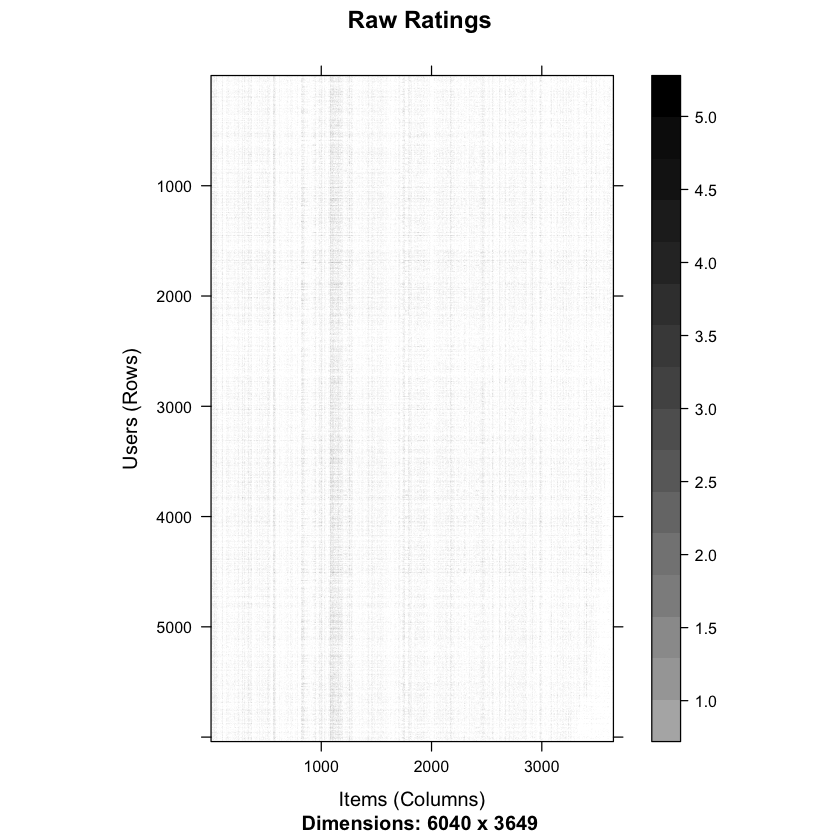

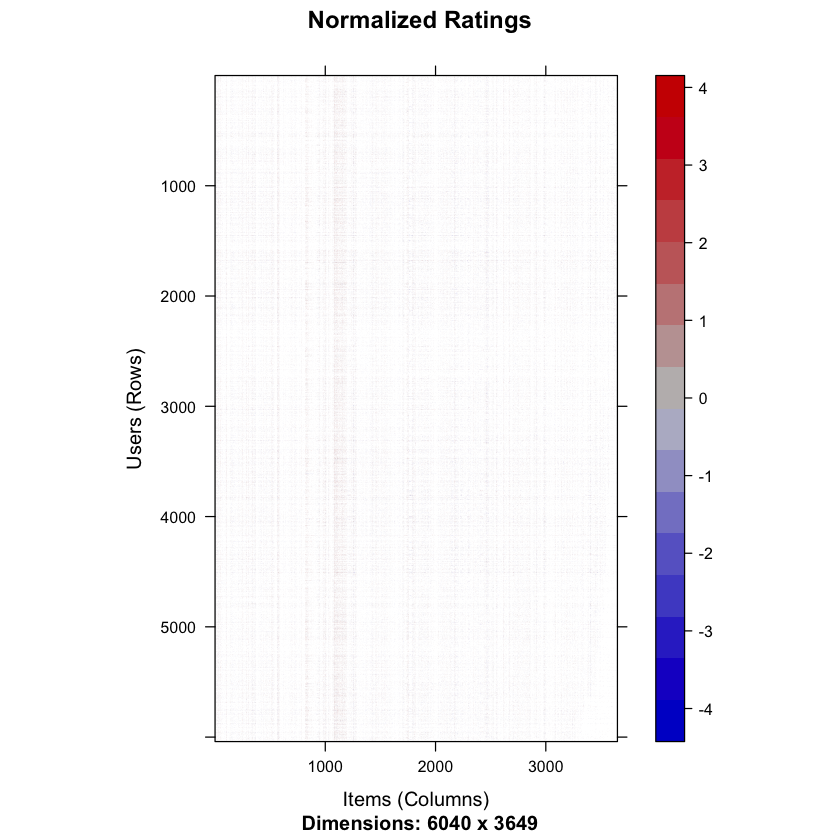

In [13]:
# Normalize the utility matrix and visualize data:
R_m = normalize(R)
head(getRatingMatrix(R_m))

# visualize
image(R, main = "Raw Ratings")
image(R_m, main = "Normalized Ratings")

In [14]:
# Learn a recommender
recommenderRegistry$get_entries(dataType="realRatingMatrix")
rec = Recommender(R, method='UBCF',
    parameter=list(normalize='Z-score', method='Cosine', nn=5, minRating=1)
)

$ALS_realRatingMatrix
Recommender method: ALS for realRatingMatrix
Description: Recommender for explicit ratings based on latent factors, calculated by alternating least squares algorithm.
Reference: Yunhong Zhou, Dennis Wilkinson, Robert Schreiber, Rong Pan (2008). Large-Scale Parallel Collaborative Filtering for the Netflix Prize, 4th Int'l Conf. Algorithmic Aspects in Information and Management, LNCS 5034.
Parameters:
  normalize lambda n_factors n_iterations min_item_nr seed
1      NULL    0.1        10           10           1 NULL

$ALS_implicit_realRatingMatrix
Recommender method: ALS_implicit for realRatingMatrix
Description: Recommender for implicit data based on latent factors, calculated by alternating least squares algorithm.
Reference: Yifan Hu, Yehuda Koren, Chris Volinsky (2008). Collaborative Filtering for Implicit Feedback Datasets, ICDM '08 Proceedings of the 2008 Eighth IEEE International Conference on Data Mining, pages 263-272.
Parameters:
  lambda alpha n_factors 

Available parameter (with default values):
method	 =  cosine
nn	 =  25
sample	 =  FALSE
normalize	 =  center
verbose	 =  FALSE


In [15]:
# A short summary of the model:
print(rec)
names(getModel(rec))

Recommender of type ‘UBCF’ for ‘realRatingMatrix’ 
learned using 6040 users.


[1] "description" "data"        "method"      "nn"          "sample"     
[6] "normalize"   "verbose"

In [16]:
# Make prediction on the test data
recom = predict(rec, R, type='ratings')  # predict ratings. This may be slow.
rec_list = as(recom, 'list')  # each element are ratings of that user

In [17]:
# read labels and test data
label = read.csv('label.csv', header=TRUE)
test = read.csv('test.csv', header=TRUE)
# test = test[with(test, order(user, movie)), ]

test$rating = NA

# For all lines in test file, one by one
for (u in 1:nrow(test)){
    # Read userid and movieid from columns 2 and 3 of test data
    userid = as.character(test$user[u])
    movieid = as.character(test$movie[u])
    
    rating = rec_list[[userid]][movieid]
    # 2.5 may be too arbitrary
    test$rating[u] = ifelse(is.na(rating), 2.5, rating)
    
}

# write submission file
write.table(test, file='mysubmission1.csv', row.names=FALSE, col.names=TRUE, sep=',')

In [44]:
# calculate RMSE
y = label[, 'rating']
y.hat = test[, 'rating']

rmse = sqrt(mean((y.hat - y)^2))
cat('Final RMSE is:\t', rmse, '\n')

Final RMSE is:	 1.01865 


In [45]:
# get the used time information
all.end.time = Sys.time()
cat('All running time\n')
cat('Start time:\t', as.character(all.start.time), '\n')
cat('End time:\t', as.character(all.end.time), '\n')
cat('Total time:\t', all.end.time - all.start.time, '\n')

All running time
Start time:	 2017-05-03 21:55:39 
End time:	 2017-05-03 22:41:11 
Total time:	 45.52289 
